<>:15: SyntaxWarning: invalid escape sequence '\p'
<>:15: SyntaxWarning: invalid escape sequence '\p'
C:\Users\compu market\AppData\Local\Temp\ipykernel_20020\1193713588.py:15: SyntaxWarning: invalid escape sequence '\p'
  DATA_DIR = 'archive\plantvillage dataset\color'  # Change this to your dataset path


Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.
Number of classes: 38


C:\Users\compu market\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1554s 1s/step - accuracy: 0.8055 - loss: 0.7553 - val_accuracy: 0.9417 - val_loss: 0.1877
Epoch 2/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1572s 1s/step - accuracy: 0.9543 - loss: 0.1509 - val_accuracy: 0.9496 - val_loss: 0.1561
Epoch 3/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1257s 924ms/step - accuracy: 0.9689 - loss: 0.1030 - val_accuracy: 0.9525 - val_loss: 0.1491
Epoch 4/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1002s 738ms/step - accuracy: 0.9768 - loss: 0.0802 - val_accuracy: 0.9589 - val_loss: 0.1229
Epoch 5/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 899s 662ms/step - accuracy: 0.9795 - loss: 0.0664 - val_accuracy: 0.9560 - val_loss: 0.1322
Training accuracy: 0.9791
Validation accuracy: 0.9560
340/340 ━━━━━━━━━━━━━━━━━━━━ 217s 635ms/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.97      0.93      0.95       126
                                 Apple___Black_rot   

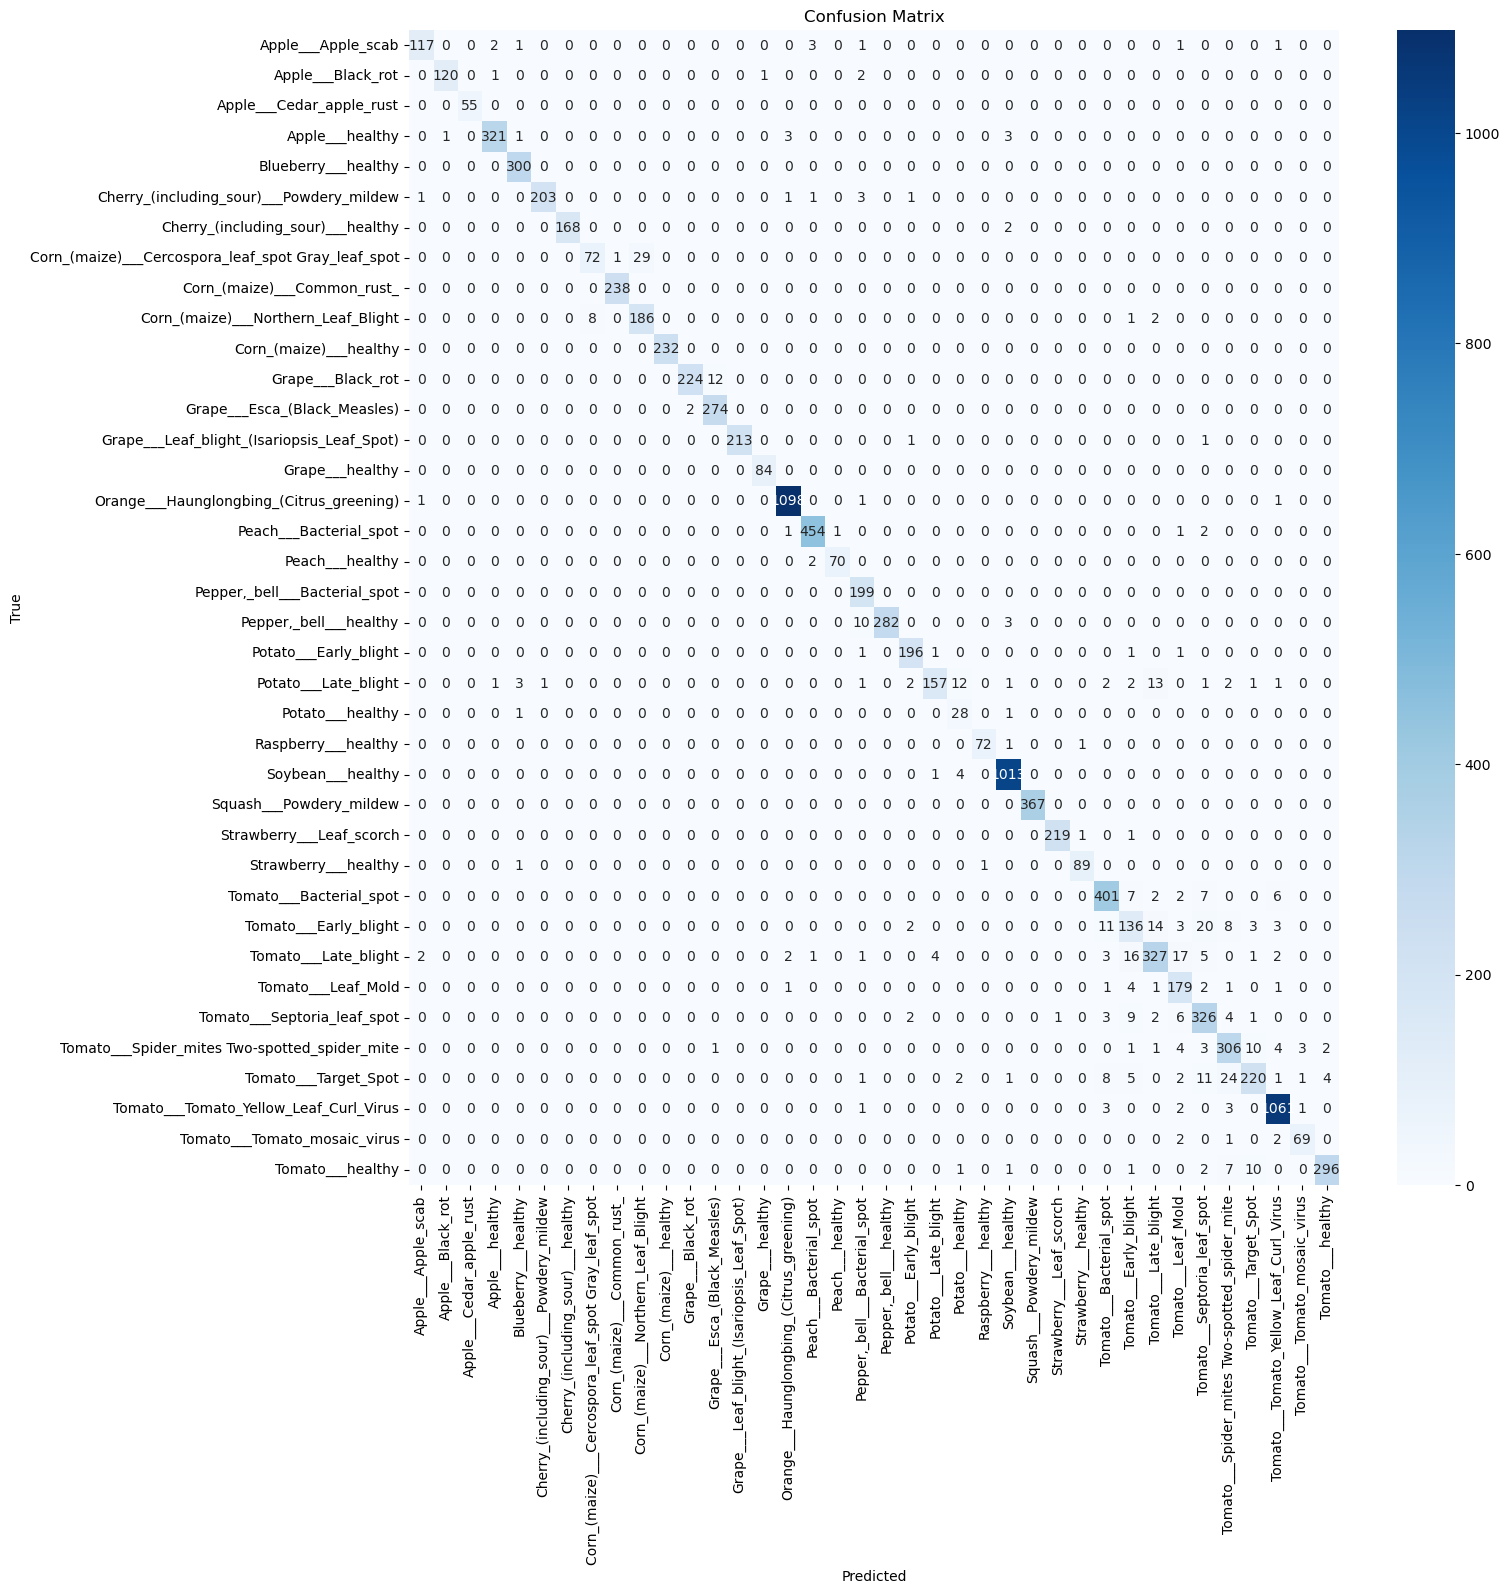

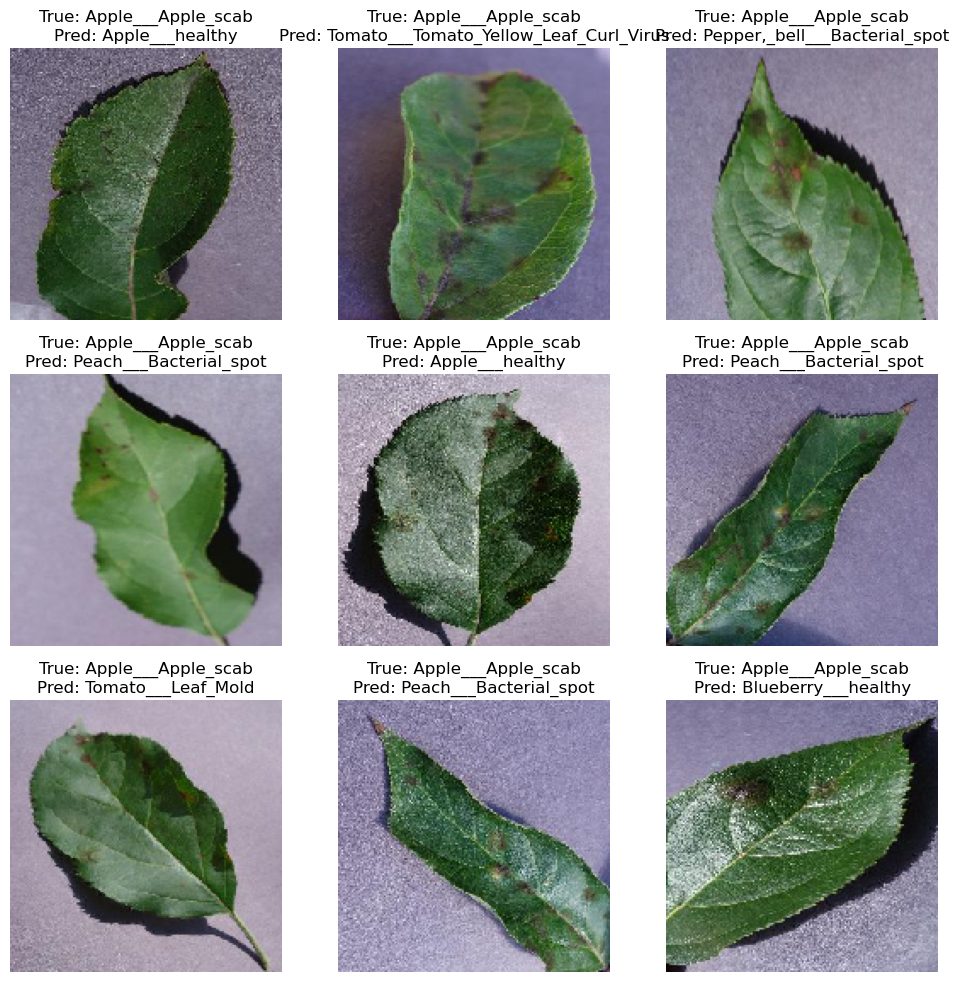

Model saved successfully


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

IMG_SIZE = (160, 160)  
BATCH_SIZE = 32
EPOCHS = 5
DATA_DIR = 'archive\plantvillage dataset\color'  

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_gen.class_indices)
print(f"Number of classes: {num_classes}")

base_model = MobileNetV2(input_shape=(*IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS)

train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Training accuracy: {train_acc:.4f}")
print(f"Validation accuracy: {val_acc:.4f}")

val_gen.reset()
preds = model.predict(val_gen)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes

print(classification_report(y_true, y_pred, target_names=list(train_gen.class_indices.keys())))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_gen.class_indices.keys(),
            yticklabels=train_gen.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

errors = np.where(y_pred != y_true)[0]
plt.figure(figsize=(12, 12))
for i, idx in enumerate(errors[:9]):
    img_path = val_gen.filepaths[idx]
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    true_label = list(train_gen.class_indices.keys())[y_true[idx]]
    pred_label = list(train_gen.class_indices.keys())[y_pred[idx]]
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')
plt.show()

model.save('plant_disease_mobilenetv2_fast.h5')
print("Model saved successfully")
